In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy.stats as stats
import tacco as tc
import os

# Sample XETG00102__0018329__lung_D239-RLL-15B3-115__20240223__200503

In [2]:
# read in matrix file
adata = sc.read_10x_h5(
    filename="/Users/stephreinert/Desktop/xenium/xenium_lung/output-XETG00102__0018329__lung_D239-RLL-15B3-115__20240223__200503/cell_feature_matrix.h5"
)

In [3]:
# read in cells.csv
df = pd.read_csv(
    "/Users/stephreinert/Desktop/xenium/xenium_lung/output-XETG00102__0018329__lung_D239-RLL-15B3-115__20240223__200503/cells.csv"
)

In [4]:
# update obs metadata with info from df
df.set_index(adata.obs_names, inplace = True)
adata.obs = df.copy()

In [5]:
adata

AnnData object with n_obs × n_vars = 344205 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
# storing x and y spatial coordinates of cells in anndata object 
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [7]:
# calculate quality control metrics and calculate cumulative sum for the top 10, 20, 50, and 150 genes
# add them to adata.obs and adata.var
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

## Pre-Filtering Negative Probe Count and Negative Decoding Count

In [8]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.007407421775928765
Negative Decoding Count %: 0.0033309151111889164


## Pre QC Metrics

In [9]:
total_cell_area_um2 = 	81693970.9
time_interval = 100000

In [10]:
# transcripts per 100 µm² (use cell area)
cells_per_square_micrometer = adata.obs['transcript_counts'].sum() / (total_cell_area_um2) * 100
print(f"Total number of transcripts per 100 um squared: {cells_per_square_micrometer:.2f}")

# total cells
print(f"Total number of cells: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total Transcripts: {total_high_quality_transcripts}")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
number_of_cells = adata.shape[0]
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Total number of genes per cell (avg): {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell: {median_transcripts}")

# percentage of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
print(f"Cells without transcripts: {cells_without_transcripts}")
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts: {percentage_without_transcripts:.2f}%")

Total number of transcripts per 100 um squared: 40.39
Total number of cells: 344205
Total Transcripts: 32993936
Median number of genes per cell: 33.00
Total number of genes per cell (avg): 33.12
Median transcripts per cell: 83.0
Cells without transcripts: 74
Percentage of cells without transcripts: 0.02%


## Filtering and Processing

In [11]:
# remove cells with fewer than 5 total gene counts
sc.pp.filter_cells(adata, min_counts=5)

# remove genes that are not expressed in any cell
sc.pp.filter_genes(adata, min_cells=1)

In [12]:
# normalize counts per cell, logarithmize, PCA, compute neighborhood graph
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)

## Initial UMAP

In [13]:
# embed the neighborhood graph of data and cluster cells into subgroups
sc.tl.umap(adata)
sc.tl.leiden(adata)

/var/folders/bv/w023d_tj3p58_zz7tkyz15540000gn/T/ipykernel_42685/3901399863.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


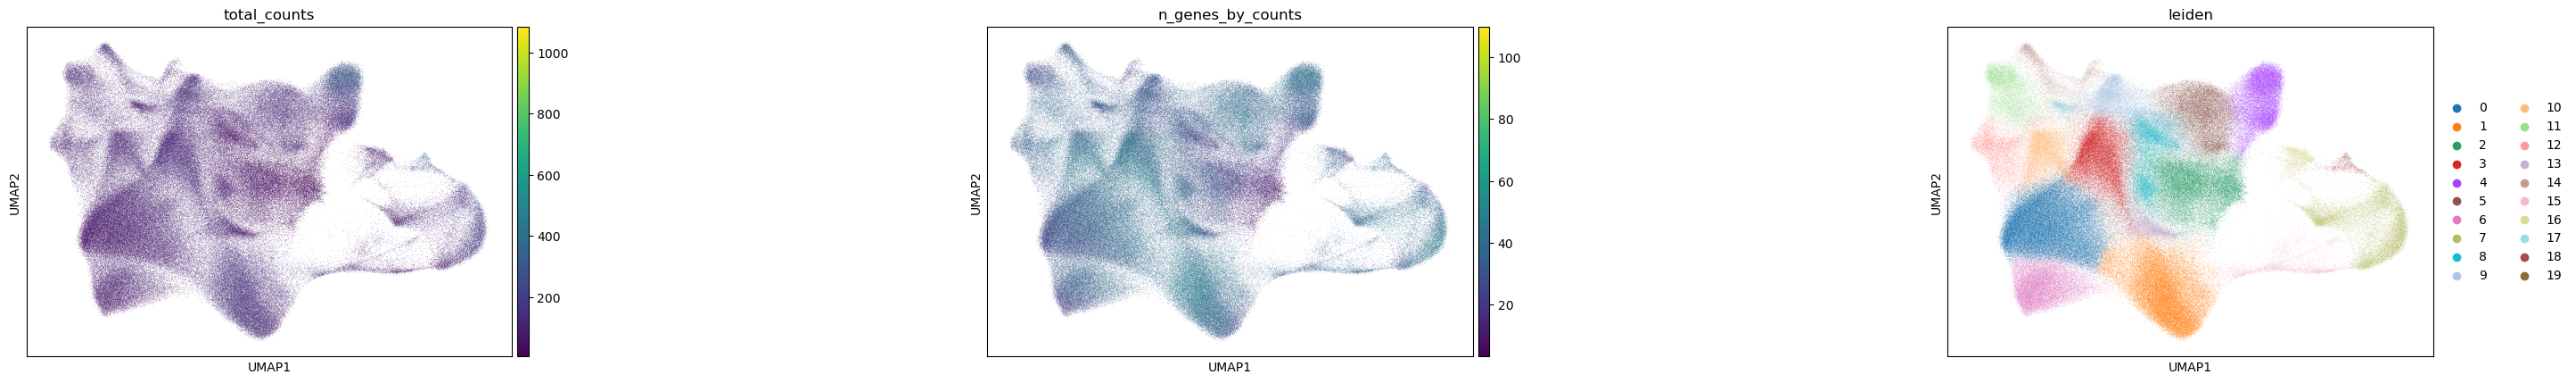

In [14]:
# umap
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.8,
)

/opt/homebrew/Caskroom/miniconda/base/envs/TACCO_env/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


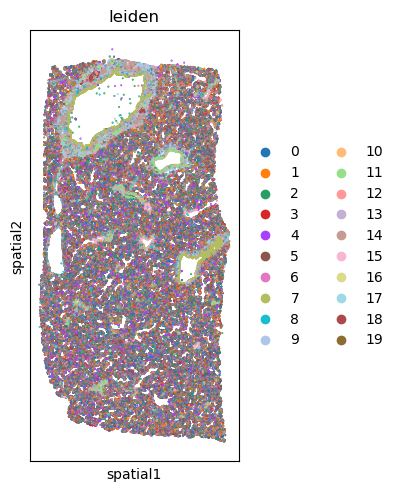

In [15]:
# spatial
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

## False Discovery Rate

In [16]:
# total transcript calls (TTC)
total_transcript_calls = adata.obs['total_counts'].sum()
print(f"Total Transcript Calls: {total_transcript_calls}")

# negative control calls (NCC)
negative_control_calls = adata.obs['control_probe_counts'].sum()
print(f"Total Negative Control Calls: {negative_control_calls}")

# number of negative control probes (NCPs)
number_of_negative_control_probes = 20 ## VERIFY!

# number of real gene probes (RGPs)
number_of_panel_genes = 300 ## VERIFY!

# calculate FDR (10x)
fdr_step1 = (negative_control_calls / total_transcript_calls) * (number_of_panel_genes / number_of_negative_control_probes)
FDR_1 = fdr_step1 * 100
print(f"False Discovery Rate Xenium (FDR%): {FDR_1}%")

# calculate FDR (squidpy)
FDR_2 = (negative_control_calls / total_transcript_calls) * 100
print(f"False Discovery Rate Squidpy (FDR%): {FDR_2}%")

Total Transcript Calls: 32989362.0
Total Negative Control Calls: 2439
False Discovery Rate Xenium (FDR%): 0.11089938629307229%
False Discovery Rate Squidpy (FDR%): 0.007393292419538153%


## Post-Filtering Negative Probe Count and Negative Decoding Count

In [17]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.007393292419538153
Negative Decoding Count %: 0.0033313769450891476


## Post-QC Metrics

In [18]:
# total cells per mm2
total_cell_area_mm = total_cell_area_um2 / 1000000
cells_per_square_millimeter = len(adata.obs) / (total_cell_area_mm)
print(f"Total number of cells per square millimeter: {cells_per_square_millimeter:.2f}")

# total transcripts per cell
number_of_cells = adata.shape[0]
total_high_quality_transcripts = adata.obs['transcript_counts'].sum() / number_of_cells
print(f"Total Transcripts per cell post-QC: {total_high_quality_transcripts}")

# total cells
print(f"Total number of cells post-QC: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total number of transcripts post-QC: {total_high_quality_transcripts}")

# average area per cell
average_cell_area = adata.obs['cell_area'].mean()
print(f"Average cell area post-QC: {average_cell_area:.2f}")

# percent of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts post-QC: {percentage_without_transcripts:.2f}%")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell post-QC: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Average number of genes per cell post-QC: {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell post-QC: {median_transcripts}")

Total number of cells per square millimeter: 4193.61
Total Transcripts per cell post-QC: 96.29314084058927
Total number of cells post-QC: 342593
Total number of transcripts post-QC: 32989356
Average cell area post-QC: 237.25
Percentage of cells without transcripts post-QC: 0.00%
Median number of genes per cell post-QC: 33.00
Average number of genes per cell post-QC: 33.26
Median transcripts per cell post-QC: 83.0


## Spatially Variable Genes

In [19]:
# calculate moran's I score
# I is the score, pval_norm is pvalue, var is variance, and corr_method is corrected p values
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

  0%|          | 0/100 [00:00<?, ?/s]

In [20]:
# inspect result
adata.uns["moranI"].head(10)

I  pval_norm      var_norm  pval_z_sim  pval_sim   var_sim  \
BPIFB1  0.801447        0.0  9.933422e-07         0.0  0.009901  0.000002   
MUC5B   0.766074        0.0  9.933422e-07         0.0  0.009901  0.000002   
RSPH1   0.741177        0.0  9.933422e-07         0.0  0.009901  0.000002   
PROM1   0.636943        0.0  9.933422e-07         0.0  0.009901  0.000002   
WFDC2   0.623285        0.0  9.933422e-07         0.0  0.009901  0.000001   
KRT5    0.621982        0.0  9.933422e-07         0.0  0.009901  0.000002   
FOXJ1   0.609131        0.0  9.933422e-07         0.0  0.009901  0.000002   
DTHD1   0.589063        0.0  9.933422e-07         0.0  0.009901  0.000002   
CP      0.583024        0.0  9.933422e-07         0.0  0.009901  0.000002   
CYP2F1  0.576347        0.0  9.933422e-07         0.0  0.009901  0.000001   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
BPIFB1               0.0                0.0         0.011446  
MUC5B                0.0                0.0         0.011446  
RSPH1                0.0                0.0         0.011446  
PROM1                0.0                0.0         0.011446  
WFDC2                0.0                0.0         0.011446  
KRT5                 0.0                0.0         0.011446  
FOXJ1                0.0                0.0         0.011446  
DTHD1                0.0                0.0         0.011446  
CP                   0.0                0.0         0.011446  
CYP2F1               0.0                0.0         0.011446

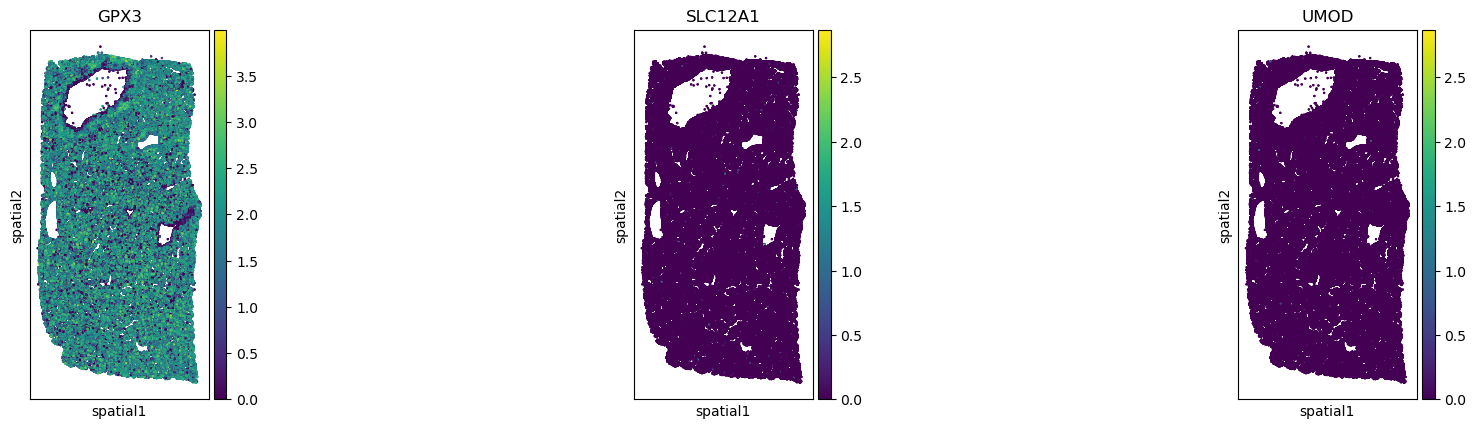

In [21]:
# plot selected highly variable genes
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "GPX3",
        "SLC12A1",
        "UMOD",
    ],
    shape=None,
    size=2,
    img=False,
)

## Gene Visualization

Error in callback <function _draw_all_if_interactive at 0x1a0f17600> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

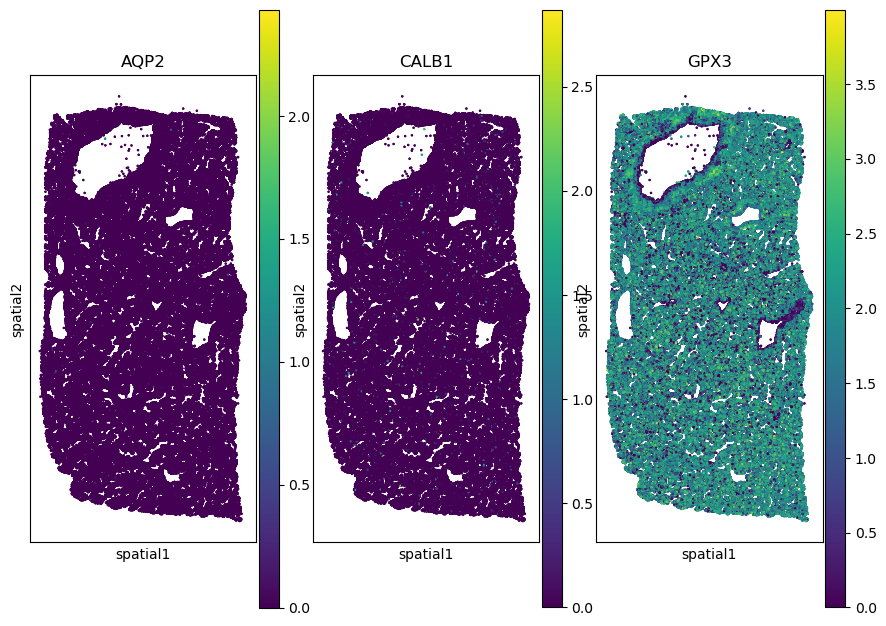

In [22]:
# visualize select genes
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "AQP2",
       "CALB1",
       "GPX3",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

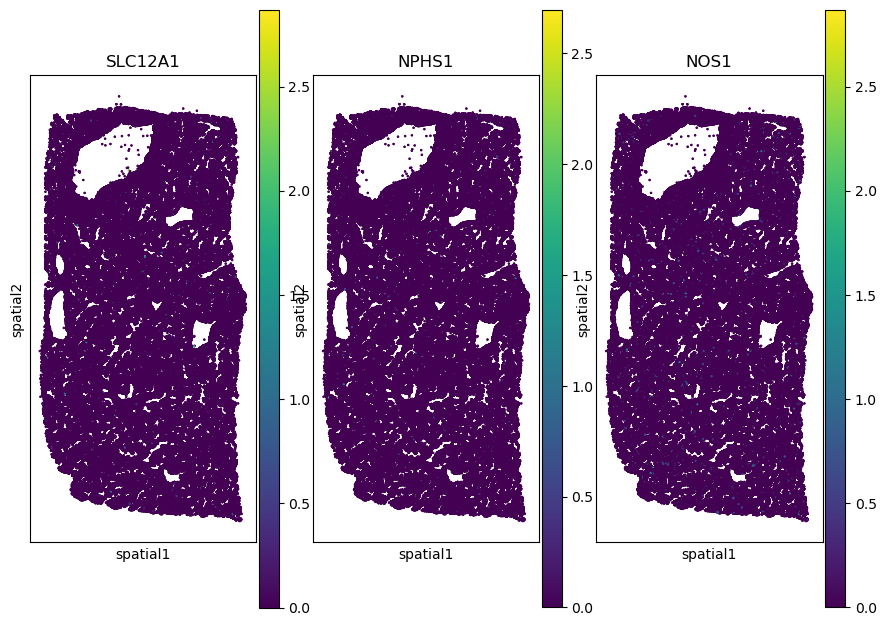

In [23]:
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "SLC12A1",
       "NPHS1",
       "NOS1",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

## Import Desired Reference Object

In [24]:
# adata_5000_nodegen = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_nodegen_5kcells.h5ad")
# adata_5000 = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_5kcells.h5ad")
adata_50prop = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/atlasv2_ds_50prop.h5ad")

## TACCO

In [25]:
tc.tl.annotate(adata, adata_50prop, annotation_key='v2.subclass.l1', result_key='v2.subclass.l1', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["v2.subclass.l1"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 74.32 seconds.
Starting annotation of data with shape (342593, 300) and a reference of shape (694299, 300) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=v2.subclass.l1, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  4.068391570923253 20.157799773161717
bisection run on 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Ex

AnnData object with n_obs × n_vars = 342593 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1'
    varm: 'PCs', 'v2.subclass.l1'
    layers: 'counts'
    obsp: 'distances', 'connectivities', 'spatial_

In [26]:
y = adata.obsm['v2.subclass.l1']
# Find the column where the value is 1.0
y['v2.subclass.l1'] = y.idxmax(axis=1)

In [27]:
adata.obs['v2.subclass.l1'] = y['v2.subclass.l1']

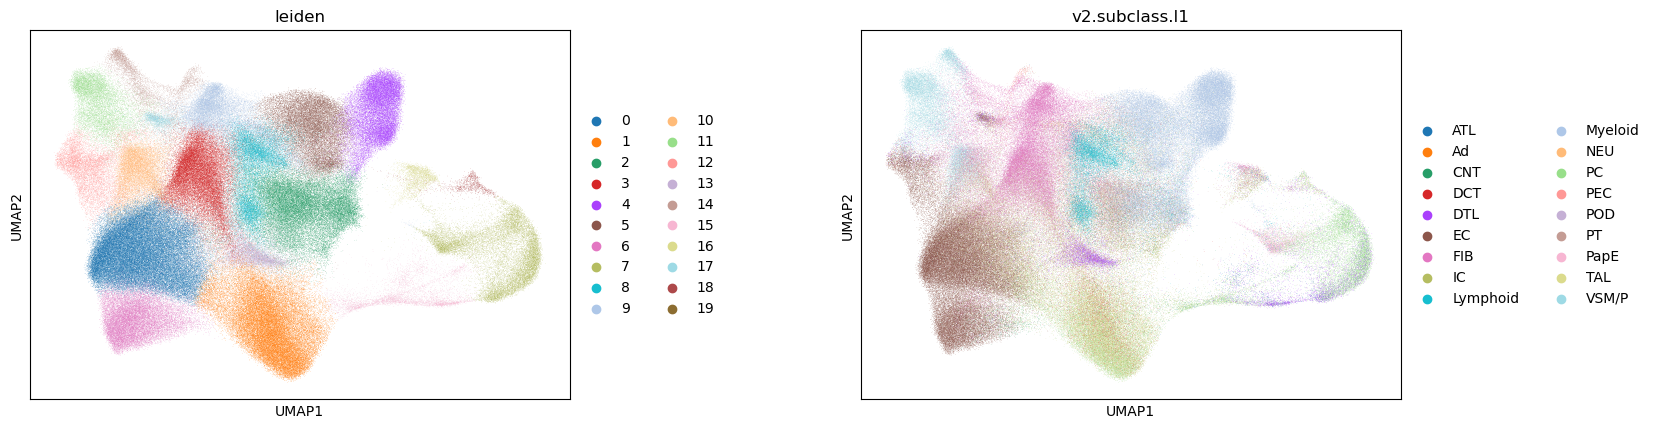

In [28]:
sc.pl.umap(
    adata,
    color=[
        "leiden",'v2.subclass.l1'
    ],
    wspace=0.4,
)

In [29]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
EC          63087
TAL         48886
Myeloid     48365
FIB         46477
PT          42488
PC          26041
VSM/P       16060
Lymphoid    15003
DTL         10827
IC           6540
DCT          5959
CNT          3341
POD          3303
PapE         2448
PEC          1884
ATL          1657
NEU           173
Ad             54
Name: count, dtype: int64

In [30]:
tc.tl.annotate(adata, adata_50prop, annotation_key='v2.subclass.l2', result_key='v2.subclass.l2', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["v2.subclass.l2"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 83.18 seconds.
Starting annotation of data with shape (342593, 300) and a reference of shape (694299, 300) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=v2.subclass.l2, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  4.068391570923253 20.157799773161717
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 46.76 s

AnnData object with n_obs × n_vars = 342593 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI', 'v2.subclass.l1_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1', 'v2.subclass.l2'
    varm: 'PCs', 'v2.subclass.l1', 'v2.subcl

In [31]:
y = adata.obsm['v2.subclass.l2']
# find the column where the value is 1.0
y['v2.subclass.l2'] = y.idxmax(axis=1)

In [32]:
adata.obs['v2.subclass.l2'] = y['v2.subclass.l2']
adata.obs

cell_id    x_centroid    y_centroid  transcript_counts  \
aaaaahcm-1  aaaaahcm-1    837.513611   7592.939941                342   
aaaaccek-1  aaaaccek-1    834.772217   7542.568848                 86   
aaaaikfj-1  aaaaikfj-1    847.039734   7334.512207                 86   
aaaanbnl-1  aaaanbnl-1    845.806824   7568.323730                 44   
aaabgcdd-1  aaabgcdd-1    839.576111   7472.439941                100   
...                ...           ...           ...                ...   
oimalehj-1  oimalehj-1  10016.400391  16193.317383                151   
oimaoaam-1  oimaoaam-1   9995.777344  16198.888672                252   
oimbadmk-1  oimbadmk-1  10015.491211  16205.969727                201   
oimbcabc-1  oimbcabc-1  10005.323242  16214.188477                167   
oimbechj-1  oimbechj-1   9991.881836  16215.181641                118   

            control_probe_counts  control_codeword_counts  \
aaaaahcm-1                     0                        0   
aaaaccek-1                     0                        0   
aaaaikfj-1                     0                        0   
aaaanbnl-1                     0                        0   
aaabgcdd-1                     0                        0   
...                          ...                      ...   
oimalehj-1                     0                        0   
oimaoaam-1                     0                        0   
oimbadmk-1                     0                        0   
oimbcabc-1                     0                        0   
oimbechj-1                     0                        0   

            unassigned_codeword_counts  deprecated_codeword_counts  \
aaaaahcm-1                           1                           0   
aaaaccek-1                           0                           0   
aaaaikfj-1                           0                           0   
aaaanbnl-1                           0                           0   
aaabgcdd-1                           0                           0   
...                                ...                         ...   
oimalehj-1                           0                           0   
oimaoaam-1                           0                           0   
oimbadmk-1                           0                           0   
oimbcabc-1                           0                           0   
oimbechj-1                           0                           0   

            total_counts   cell_area  ...  log1p_n_genes_by_counts  \
aaaaahcm-1         342.0  279.426885  ...                 3.713572   
aaaaccek-1          86.0  306.972199  ...                 3.663562   
aaaaikfj-1          86.0  120.792973  ...                 3.526361   
aaaanbnl-1          44.0  203.474070  ...                 2.944439   
aaabgcdd-1         100.0  825.365967  ...                 3.465736   
...                  ...         ...  ...                      ...   
oimalehj-1         151.0  266.783135  ...                 3.951244   
oimaoaam-1         252.0  248.585165  ...                 4.189655   
oimbadmk-1         201.0  307.604386  ...                 4.007333   
oimbcabc-1         167.0  247.185321  ...                 4.007333   
oimbechj-1         118.0  255.132822  ...                 3.713572   

            log1p_total_counts  pct_counts_in_top_10_genes  \
aaaaahcm-1            5.837730                   72.807018   
aaaaccek-1            4.465908                   63.953488   
aaaaikfj-1            4.465908                   68.604651   
aaaanbnl-1            3.806663                   81.818182   
aaabgcdd-1            4.615120                   72.000000   
...                        ...                         ...   
oimalehj-1            5.023880                   56.953642   
oimaoaam-1            5.533390                   55.555556   
oimbadmk-1            5.308268                   60.696517   
oimbcabc-1            5.123964                   53.293413   
oimbechj-1            4.779123           

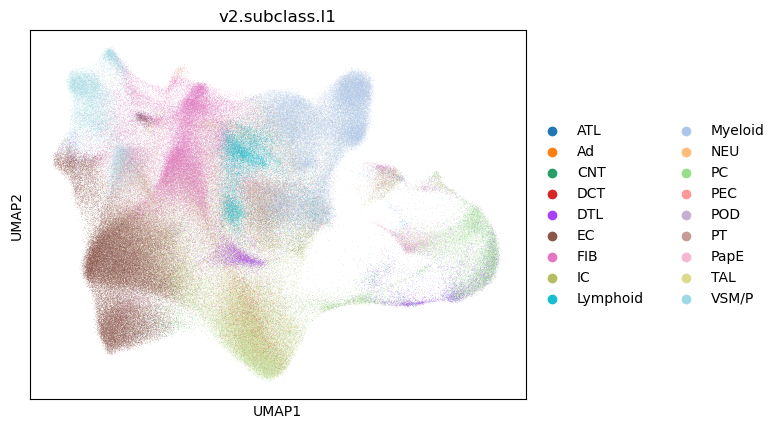

In [33]:
sc.pl.umap(adata, color=['v2.subclass.l1'], save="3781_Xen3_umap_l1.png")

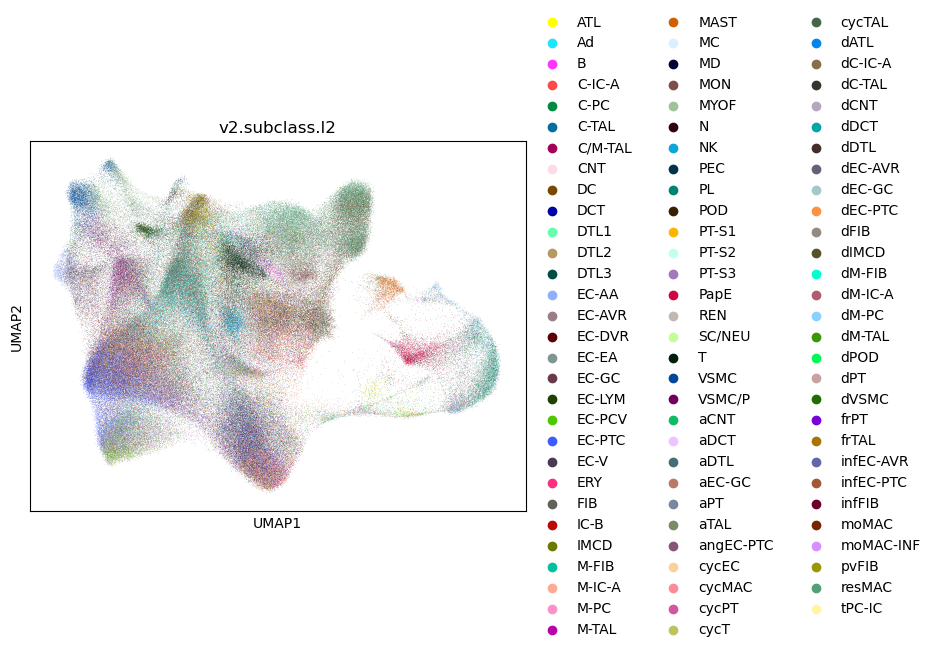

In [34]:
sc.pl.umap(adata, color=['v2.subclass.l2'], save="3781_Xen3_umap_l2.png")

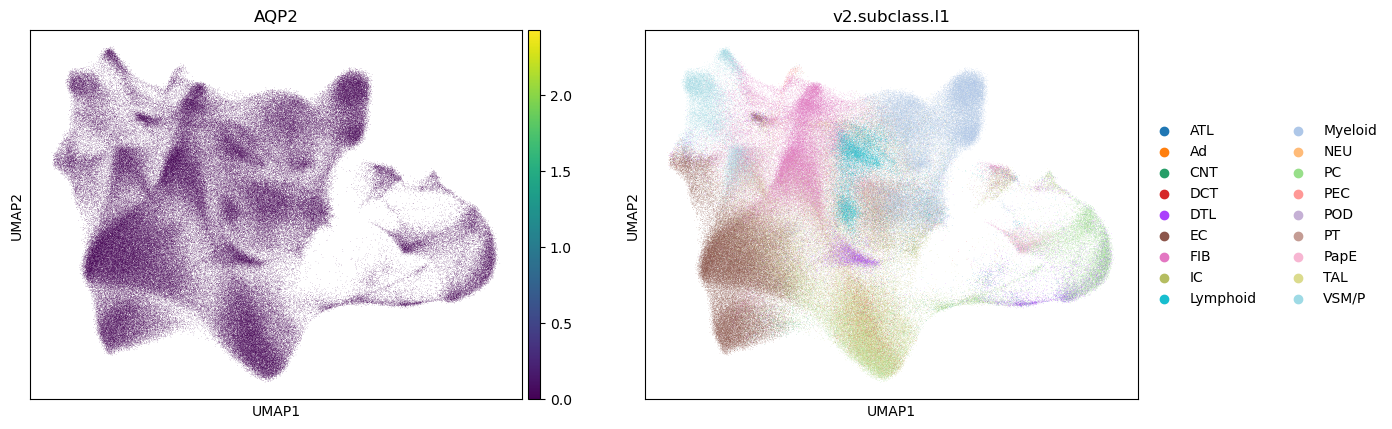

In [35]:
sc.pl.umap(adata, color=['AQP2','v2.subclass.l1'])

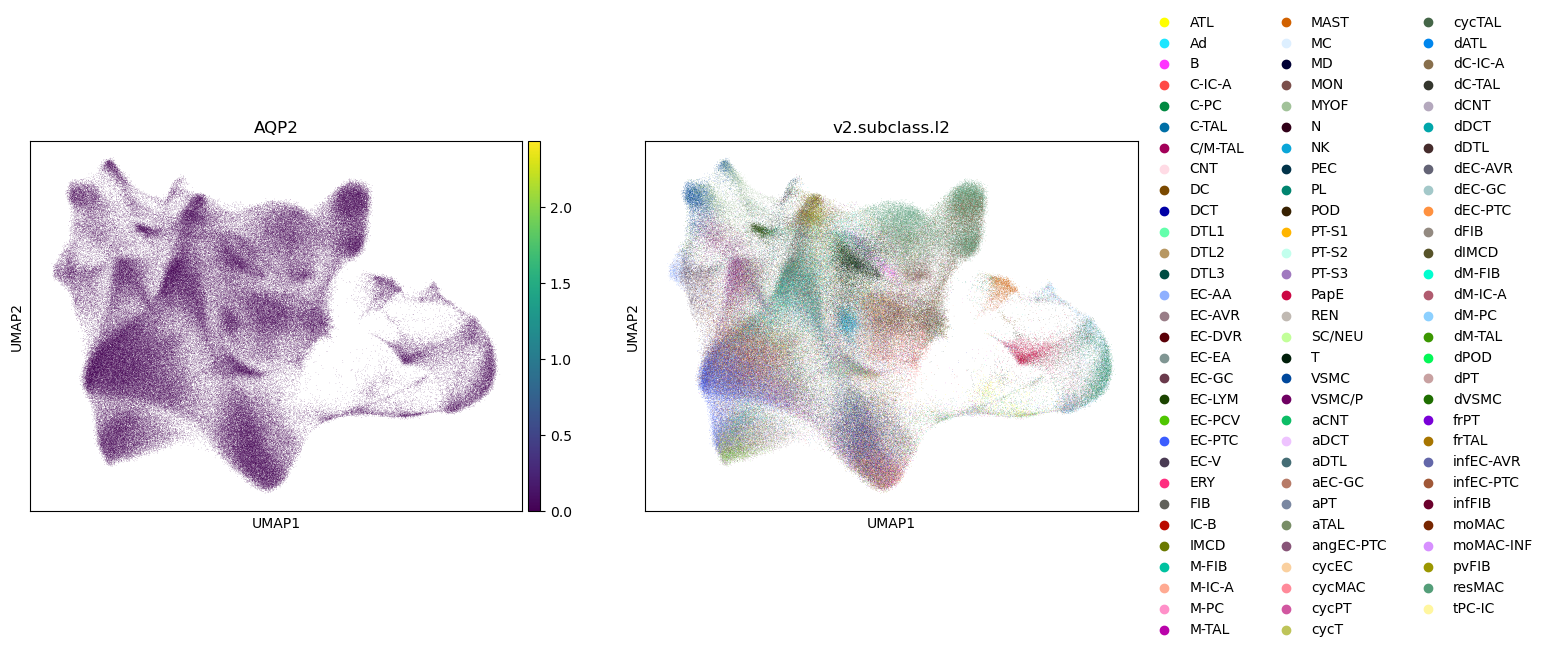

In [36]:
sc.pl.umap(adata, color=['AQP2','v2.subclass.l2'])

/opt/homebrew/Caskroom/miniconda/base/envs/TACCO_env/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


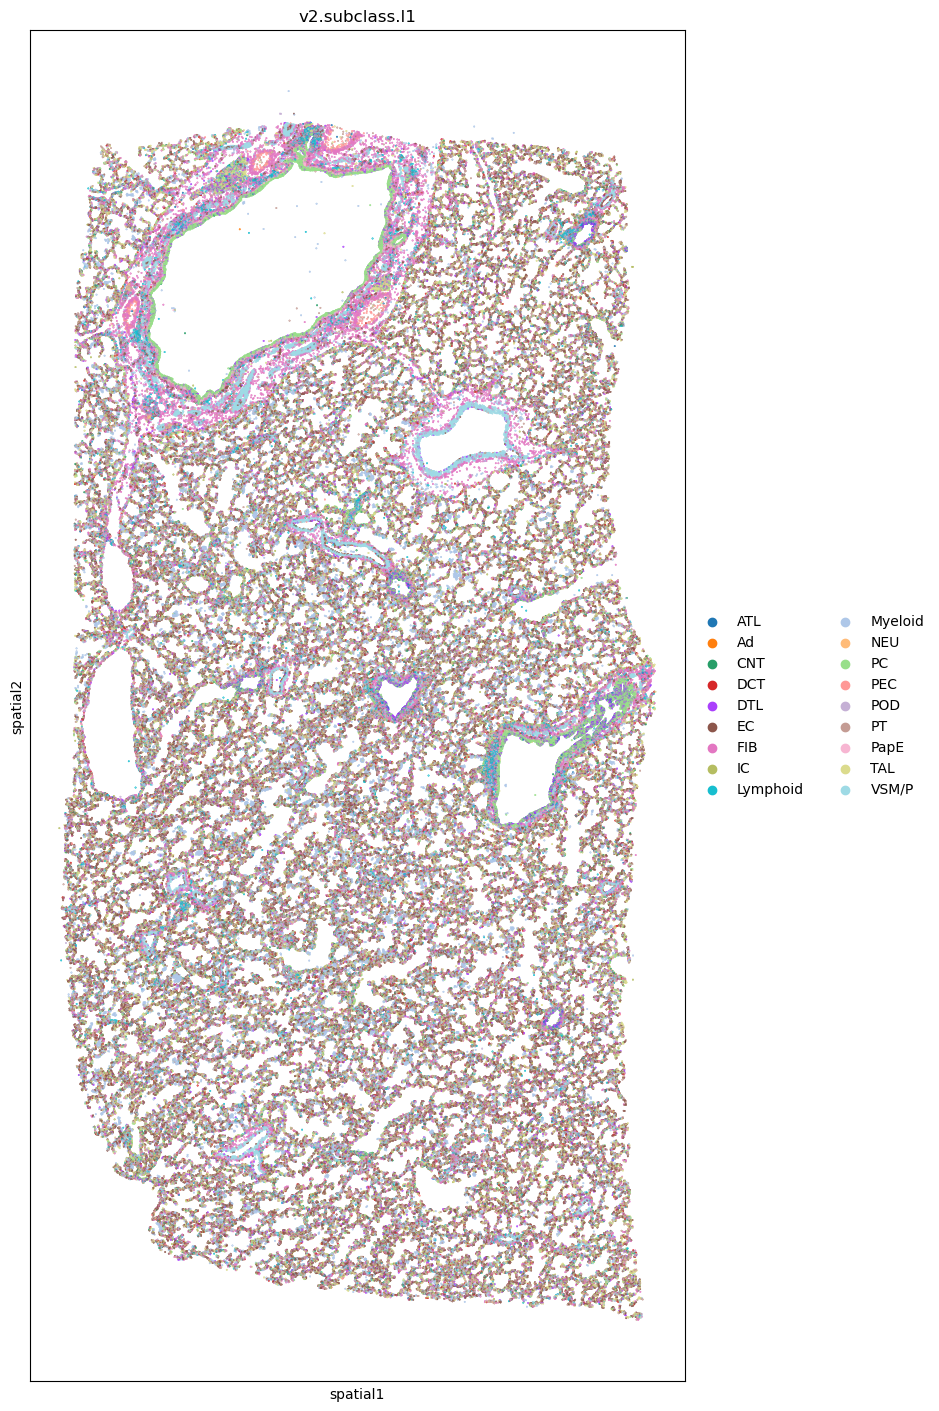

In [37]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    figsize = (16,14),
    color=[
        "v2.subclass.l1",
    ],
)

plt.savefig('/Users/stephreinert/Desktop/xenium/figures/3781_Xen3_spatial_scatter_plot.png', dpi=300, bbox_inches='tight')

In [38]:
pd.crosstab(index=adata.obs['v2.subclass.l2'], columns=adata.obs['v2.subclass.l1'])

v2.subclass.l1  ATL  Ad  CNT  DCT  DTL   EC   FIB    IC  Lymphoid  Myeloid  \
v2.subclass.l2                                                               
ATL             717   0    9   13  252    5     8    53         1        4   
Ad                0  28    0    2    0   13    23     0         0        0   
B                12   0    2   16   37   26    72    26       938      228   
C-IC-A           10   1   61   86   97  185   154  2495        97      498   
C-PC             15   0   51   19  449   12     4    24         4        2   
...             ...  ..  ...  ...  ...  ...   ...   ...       ...      ...   
moMAC             1   0    2    0    0    1     0     6         3     3280   
moMAC-INF         0   0    0    0    0    1     0     1         4      386   
pvFIB             4   0    0    8    4    2  4209     5         8       10   
resMAC            6   0   19   29   22  259   255    64       113    27718   
tPC-IC            0   0    0    0    0    0     0     1         0        0   

v2.subclass.l1  NEU    PC  PEC  POD    PT  PapE  TAL  VSM/P  
v2.subclass.l2                                               
ATL               0   232    0    0    34     2  291      1  
Ad                0     0    1    0    32     0    4      0  
B                 1    22    8   98   408     1   72      0  
C-IC-A            0   419   20   62   672     1  874      1  
C-PC              0  3846    0    0    23     0  303      0  
...             ...   ...  ...  ...   ...   ...  ...    ...  
moMAC             0     0    0    2    11     0    9      0  
moMAC-INF         0     1    0    0     1     0    6      0  
pvFIB             0     0   18   15   102     3   16      0  
resMAC            2    19    1   29  1235     2  477     11  
tPC-IC            0    23    0    0     0     0   13      0  

[89 rows x 18 columns]

In [39]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
EC          63087
TAL         48886
Myeloid     48365
FIB         46477
PT          42488
PC          26041
VSM/P       16060
Lymphoid    15003
DTL         10827
IC           6540
DCT          5959
CNT          3341
POD          3303
PapE         2448
PEC          1884
ATL          1657
NEU           173
Ad             54
Name: count, dtype: int64

In [40]:
# calculate the value counts
value_counts = adata.obs['v2.subclass.l2'].value_counts()

# convert the value counts to a DataFrame
value_counts_df = value_counts.reset_index()

# rename columns for better readability
value_counts_df.columns = ['v2.subclass.l2', 'count']

# set pandas option to display all rows
pd.set_option('display.max_rows', None)

# display
print(value_counts_df)

   v2.subclass.l2  count
0          resMAC  30261
1          EC-PTC  17993
2             FIB  17896
3           M-FIB  12727
4           PT-S1  12284
5               T  11335
6          EC-DVR   9407
7          EC-AVR   9080
8             aPT   8750
9             DCT   8694
10         VSMC/P   7814
11          C-TAL   7285
12            MON   7004
13          M-TAL   6711
14        C/M-TAL   6619
15          PT-S3   6524
16            dPT   6382
17           MYOF   6110
18          dM-PC   5963
19            CNT   5826
20         C-IC-A   5733
21             DC   5182
22         dM-TAL   5089
23           VSMC   4971
24           C-PC   4752
25          frTAL   4542
26          pvFIB   4404
27           IMCD   4396
28           M-PC   4375
29           DTL1   4201
30          EC-GC   4085
31        dEC-PTC   4071
32         dM-FIB   3606
33           PapE   3428
34          moMAC   3315
35             MD   3261
36           aTAL   3210
37            PEC   2994
38           IC-B   2859


In [41]:
# transcript count per cell type in v2.subclass.l1
transcript_counts_per_type = adata.obs.groupby('v2.subclass.l1', observed=True)['transcript_counts'].sum()
transcript_counts_per_type_df = transcript_counts_per_type.reset_index()
transcript_counts_per_type_df = transcript_counts_per_type_df.sort_values(by='transcript_counts', ascending=False)
print(transcript_counts_per_type_df)

# save to an Excel file
#transcript_counts_per_type_df.to_excel("transcript_counts_per_cell_type_l1.xlsx", index=False# number of cells per cell type in 'v2.subclass.l1'
cell_counts_per_type = adata.obs['v2.subclass.l1'].value_counts(sort=False)
cell_counts_per_type_df = cell_counts_per_type.reset_index()
cell_counts_per_type_df.columns = ['v2.subclass.l1', 'cell_count']

# proportion of cells per cell type in 'v2.subclass.l1'
cell_proportion_per_type = adata.obs['v2.subclass.l1'].value_counts(normalize=True, sort=False) * 100
cell_proportion_per_type_df = cell_proportion_per_type.reset_index()
cell_proportion_per_type_df.columns = ['v2.subclass.l1', 'proportion (%)']

# merge 
cell_counts_and_proportions_df = pd.merge(cell_counts_per_type_df, cell_proportion_per_type_df, on='v2.subclass.l1')

# sort and print
cell_counts_and_proportions_df = cell_counts_and_proportions_df.sort_values(by='cell_count', ascending=False)
print(cell_counts_and_proportions_df)

# save to excel
output_file_path = "/Users/stephreinert/Desktop/xenium/stats/3781_Xen3_subclass_counts_l1.xlsx"
cell_counts_and_proportions_df.to_excel(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

   v2.subclass.l1  transcript_counts
16            TAL            5663904
9         Myeloid            5584437
6             FIB            5033167
5              EC            4844126
11             PC            3338838
14             PT            3151765
17          VSM/P            1707381
4             DTL            1043831
8        Lymphoid             830344
3             DCT             623349
7              IC             332423
2             CNT             252355
15           PapE             194591
0             ATL             134537
13            POD             131854
12            PEC             110359
10            NEU              11094
1              Ad               1001
   v2.subclass.l1  cell_count  proportion (%)
5              EC       63087       18.414562
16            TAL       48886       14.269410
9         Myeloid       48365       14.117335
6             FIB       46477       13.566243
14             PT       42488       12.401888
11             PC    

In [42]:
# number of cells per cell type in 'v2.subclass.l2'
cell_counts_per_type = adata.obs['v2.subclass.l2'].value_counts(sort=False)
cell_counts_per_type_df = cell_counts_per_type.reset_index()
cell_counts_per_type_df.columns = ['v2.subclass.l2', 'cell_count']

# proportion of cells per cell type in 'v2.subclass.l2'
cell_proportion_per_type = adata.obs['v2.subclass.l2'].value_counts(normalize=True, sort=False) * 100
cell_proportion_per_type_df = cell_proportion_per_type.reset_index()
cell_proportion_per_type_df.columns = ['v2.subclass.l2', 'proportion (%)']

# merge 
cell_counts_and_proportions_df = pd.merge(cell_counts_per_type_df, cell_proportion_per_type_df, on='v2.subclass.l2')

# sort and print
cell_counts_and_proportions_df = cell_counts_and_proportions_df.sort_values(by='cell_count', ascending=False)
print(cell_counts_and_proportions_df)

# save to excel
output_file_path = "/Users/stephreinert/Desktop/xenium/stats/3781_Xen3_subclass_counts_l2.xlsx"
cell_counts_and_proportions_df.to_excel(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

   v2.subclass.l2  cell_count  proportion (%)
87         resMAC       30261        8.832930
20         EC-PTC       17993        5.252005
23            FIB       17896        5.223691
26          M-FIB       12727        3.714904
40          PT-S1       12284        3.585596
46              T       11335        3.308591
15         EC-DVR        9407        2.745824
14         EC-AVR        9080        2.650375
53            aPT        8750        2.554051
9             DCT        8694        2.537705
48         VSMC/P        7814        2.280841
5           C-TAL        7285        2.126430
33            MON        7004        2.044408
29          M-TAL        6711        1.958884
6         C/M-TAL        6619        1.932030
42          PT-S3        6524        1.904300
77            dPT        6382        1.862852
34           MYOF        6110        1.783457
74          dM-PC        5963        1.740549
7             CNT        5826        1.700560
3          C-IC-A        5733     

## Add Metadata

In [43]:
adata.obs['sample_id'] = 'K2200084_7'
adata.obs['library_id'] = 'Xen_3'
adata.obs['Panel'] = '300KID'
adata.obs['PPID'] = '3781'
adata.obs['Condition'] = 'Ref'
adata.obs['sample_source'] = 'Nephrectomy'
adata.obs['time_interval'] = '16'
adata.obs['region'] = 'Cortex_Medulla'
adata.obs['full_id'] = '3781_Xen3'

In [44]:
adata

AnnData object with n_obs × n_vars = 342593 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1', 'v2.subclass.l2', 'sample_id', 'library_id', 'Panel', 'PPID', 'Condition', 'sample_source', 'time_interval', 'region', 'full_id'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI', 'v2.subclass.

## Save Object

In [45]:
# remove a specific key from the obsm attribute, e.g., 'v2.subclass.l1'
del adata.obsm['v2.subclass.l1']

# remove another specific key from the obsm attribute, e.g., 'v2.subclass.l2'
del adata.obsm['v2.subclass.l2']

# remove a specific key from the varm attribute, e.g., 'v2.subclass.l1'
del adata.varm['v2.subclass.l1']

# remove another specific key from the varm attribute, e.g., 'v2.subclass.l2'
del adata.varm['v2.subclass.l2']

In [46]:
adata.write_h5ad("/Users/stephreinert/Desktop/xenium/objects/3781_Xen3_obj.h5ad")